# Loading the built dataset and plotting findings
This notebook will load the final dataset and show example trips

In [ ]:
# install packages, set correct path
Load=True #if loading, we do not read from shp files. we read from pickle for speed
path='/content/drive/My Drive/GIS' #Your path
path='/content/drive/My Drive/Pavement/GIS/' #Egemen Path
from google.colab import drive
drive.mount('/content/drive')
import sys
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colorbar as colorbar
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
os.chdir(path)
!pip install osmnx
import osmnx as ox
import networkx as nx
import pickle
from shapely.geometry import LineString, Point,MultiLineString
import json
!pip install contextily
import contextily as ctx
from pyproj import CRS,Transformer
from matplotlib.transforms import ScaledTranslation
!pip install cartopy
import cartopy.crs as ccrs
sns.set()

Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.4/101.4 kB 647.3 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 37.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 15.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 kB 5.5 MB/s eta 0:00:00
  Created wheel for cartopy: filename=Cartopy-0.21.1-cp310-cp310-linux_x86_64.whl size=11080591 sha256=f280a0141316d9a0361c02170f9da35de5e6a57ebe29cfc52ae24afd41e94b12
  Stored in directory: /root/.cache/pip/wheels/30/b0/1a/1c1909e00c76653dc4e2ff48555257c0eb2d1698280c8d9955
Successfully built cartopy


Reading the files, may take a while

In [ ]:
EJ=pd.read_pickle('pickle/EJ.pkl')
LODESOld=pd.read_pickle('pickle/LODES.pkl')
LODES=pd.read_pickle('pickle/LODESMatchNode.pkl')
Trips=pd.read_pickle('pickle/TripSummary.pkl')
Trips['Community_Type'] = ['EJ' if ej > 0 else 'Non-EJ' for ej in Trips['Number_EJ']]

# Repeat rows in the DataFrame by the values in 'Number_People'
Trips = Trips.loc[Trips.index.repeat(Trips['Number_People'])]

# Reset index to account for repeated rows
Trips.reset_index(drop=True, inplace=True)

# Set 'Number_People' to 1 in all rows
Trips['Number_People'] = 1

Trips=Trips[Trips.Number_People>0] #removes the ones with no path
Tripsl2=Trips.copy()
Tripsl2=Tripsl2[Tripsl2.length>5] #dist bigger than 2 miles only for fuel consumption
Trips=Trips.reset_index()
Tripsl2=Tripsl2.reset_index()
#load the graph
with open('pickle/G.gpickle', 'rb') as f:
  G = pickle.load(f)
nodes=pd.read_pickle('pickle/nodes.pkl')
edges=pd.read_pickle('pickle/edges.pkl')

#Define the function for extracting shortest path from edges
def shortest_path_data(shortest_path,edges):
  # Convert the shortest path to a NumPy array
  shortest_path_np = np.array(shortest_path)

  # Create an array of edge pairs
  edge_pairs_np = np.column_stack([shortest_path_np[:-1], shortest_path_np[1:]])

  # Convert the edge pairs array to a list of tuples and add the third index
  edge_list = [(*map(int, edge), 0) for edge in edge_pairs_np]

  # Add the reverse direction for each edge to the list
  edge_list += [(*map(int, edge[::-1]), 0) for edge in edge_pairs_np]

  # Get the edge pairs as a MultiIndex
  edge_pairs_index = pd.MultiIndex.from_tuples(edge_list, names=edges.index.names)

  # Now use this MultiIndex to create the shortest_path_edges DataFrame
  shortest_path_edges = edges[edges.index.isin(edge_pairs_index)]

  return edge_pairs_index,shortest_path_edges

# Select an index and display the trip info from the built dataset
From Trips, we can select index, then find nodes from LODES dataset and calculate the shortest path to display

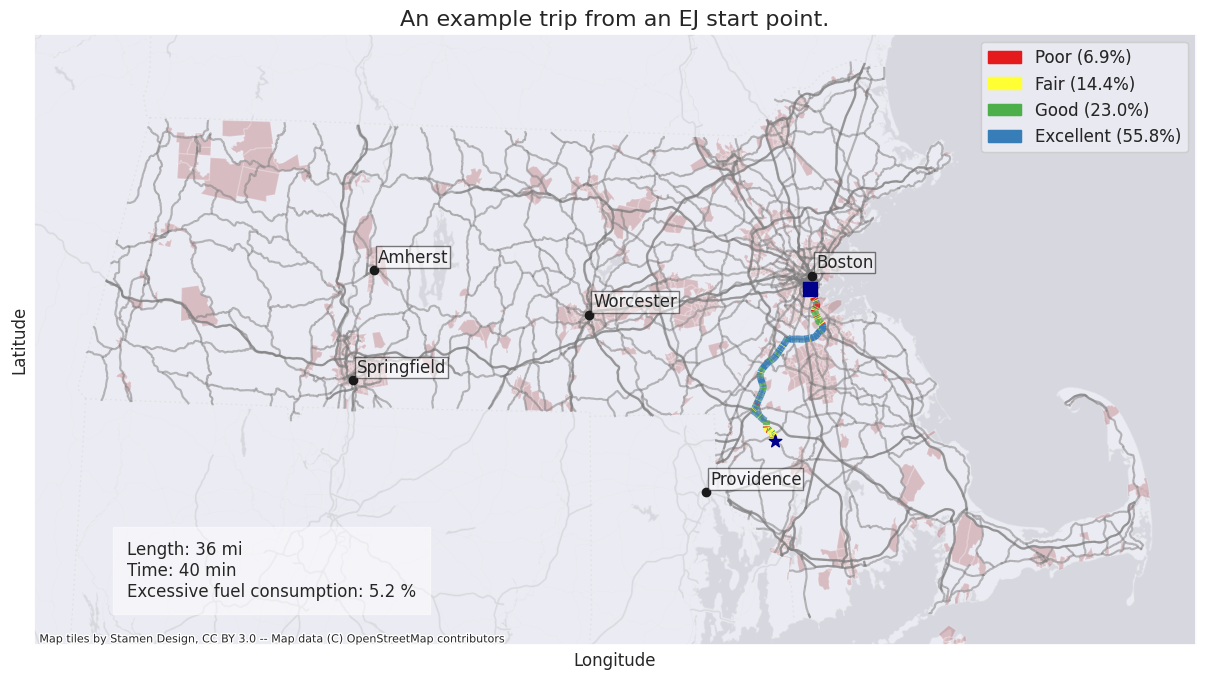

In [ ]:
index=index=np.where((Trips.Number_EJ > 0) & (Trips.length > 30))[0][12346]

font_text=12
font_title=16

# find the LODES indices for source and target nodes
LODES_index=json.loads(Trips.loc[index,'LODES_index'])
home_node=LODES.loc[LODES_index[0],'h_node']
work_node=LODES.loc[LODES_index[0],'w_node']

# calculate shortest path and return the matching edges
shortest_path = nx.shortest_path(G, home_node, work_node, weight='time')
edge_pairs_index, shortest_path_edges = shortest_path_data(shortest_path, edges)

# Create a color map for the conditions
color_map = {'Poor': 'red', 'Fair': 'orange', 'Good': 'green', 'Excellent': 'blue'}
color_map = {'Poor': '#fde725', 'Fair': '#35b778', 'Good': '#31688d', 'Excellent': '#440154'}
cmap = plt.cm.Set1

# Create a color map for the conditions
color_map = {'Poor': cmap(0), 'Fair': cmap(5), 'Good': cmap(2), 'Excellent': cmap(1)}  # You can change the color indices to select the colors you want

# Define a color map and a linestyle map
color_map = {'Poor': cmap(0), 'Fair': cmap(5), 'Good': cmap(2), 'Excellent': cmap(1)}
linestyle_map = {'Poor': '--', 'Fair': ':', 'Good': '-.', 'Excellent': '-'}

# Create a new column in the DataFrame that maps the condition to a color
# Make a copy of the dataframe before assigning colors
shortest_path_edges = shortest_path_edges.copy()
shortest_path_edges['color'] = shortest_path_edges['Condition'].map(color_map)


# Calculate total length of each condition
total_lengths = shortest_path_edges.groupby('Condition')['length'].sum()

# Calculate the percentage of total length for each condition
total_length = shortest_path_edges['length'].sum()
percentage_lengths = total_lengths / total_length * 100



# Plot the roads
edgescrs = edges.to_crs(epsg=3857)  # contextily requires data in Web Mercator projection (epsg:3857)
EJcrs = EJ.to_crs(epsg=3857)  # contextily requires data in Web Mercator projection (epsg:3857)
shortest_path_edges = shortest_path_edges.to_crs(epsg=3857)
fig, ax = plt.subplots(figsize=(15, 15))

edgescrs.plot(ax=ax, color='gray', alpha=0.6)
shortest_path_edges.plot(ax=ax, color=shortest_path_edges['color'], linewidth=5)


# Add a title and labels
EJcheck=Trips.loc[index,'Number_EJ']>0
if EJcheck:
  strr="an EJ"
else:
  strr="a non-EJ"
plt.title("An example trip from " +strr+ ' start point.', fontsize=font_title)
ax.set_ylabel("Latitude", fontsize=font_text)
ax.set_xlabel("Longitude", fontsize=font_text)

# Increase the font size of the tick labels
ax.tick_params(axis='both', which='major', labelsize=font_text)

# Add the base map
ctx.add_basemap(ax, source=ctx.providers.Stamen.TonerBackground, alpha=0.08)
# List of cities with corresponding coordinates

# Define the coordinate systems
crs_wgs = CRS("EPSG:4326")  # WGS84 coordinate system
crs_merc = CRS("EPSG:3857")  # Web Mercator coordinate system

# Create a transformer
transformer = Transformer.from_crs(crs_wgs, crs_merc)

# List of cities with corresponding coordinates
cities = {
    'Boston': (-71.0589, 42.3601),
    'Providence': (-71.4128, 41.8240),
    'Springfield': (-72.5898, 42.1015),
    'Worcester': (-71.8023, 42.2626),
    'Amherst': (-72.5199, 42.3732)
}

# Convert the coordinate of the city to Web Mercator
cities = {city: transformer.transform(lat, lon) for city, (lon, lat) in cities.items()}

# Add each city to the plot
for city, (x, y) in cities.items():
    ax.text(x, y, city, fontsize=12, ha='left', va='bottom',
            transform=ax.transData + ScaledTranslation(3/72, 3/72, fig.dpi_scale_trans),
            bbox=dict(facecolor='white', alpha=0.5, edgecolor='black', boxstyle='square,pad=0.1'))
    ax.plot(x, y, 'ko')  # 'ko' creates a black circle marker




# Plot EJ with dark red color and transparency
EJcrs.plot(ax=ax, color='darkred', alpha=0.2)
# Create the legend patches for road conditions, add percentage to the labels

start_node, end_node = G.nodes[home_node], G.nodes[work_node]
ax.scatter(start_node['x'], start_node['y'], c='darkblue', s=100, marker='s',zorder=10) # start is marked with a square
ax.scatter(end_node['x'], end_node['y'], c='darkblue', s=90, marker='*',zorder=10) # end is marked with a star

patches = [mpatches.Patch(color=color, label=f'{condition} ({percentage_lengths[condition]:.1f}%)') for condition, color in color_map.items()]

# Add the legend manually to the current Axes
leg1 = ax.legend(handles=patches, loc='upper right',fontsize=font_text)
ax.add_artist(leg1)

ax.grid(False)

# Hide axes ticks
ax.set_xticks([])
ax.set_yticks([])

# Box with details
xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()
length=int(np.round(Trips.loc[index]['length']))
time=int(np.round(Trips.loc[index]['time']))
fuel=np.round(Trips.loc[index]['Percent_fuel_high']*100,1) #this is a wrong value
info_text = f"Length: {length} mi\nTime: {time} min\nExcessive fuel consumption: {fuel} %"
plt.text(xmin + 0.08*(xmax-xmin), ymin + 0.08*(ymax-ymin), info_text, fontsize=font_text, bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 10})

plt.savefig("plots/exampleEJ.png", dpi=300,bbox_inches='tight')


plt.show()


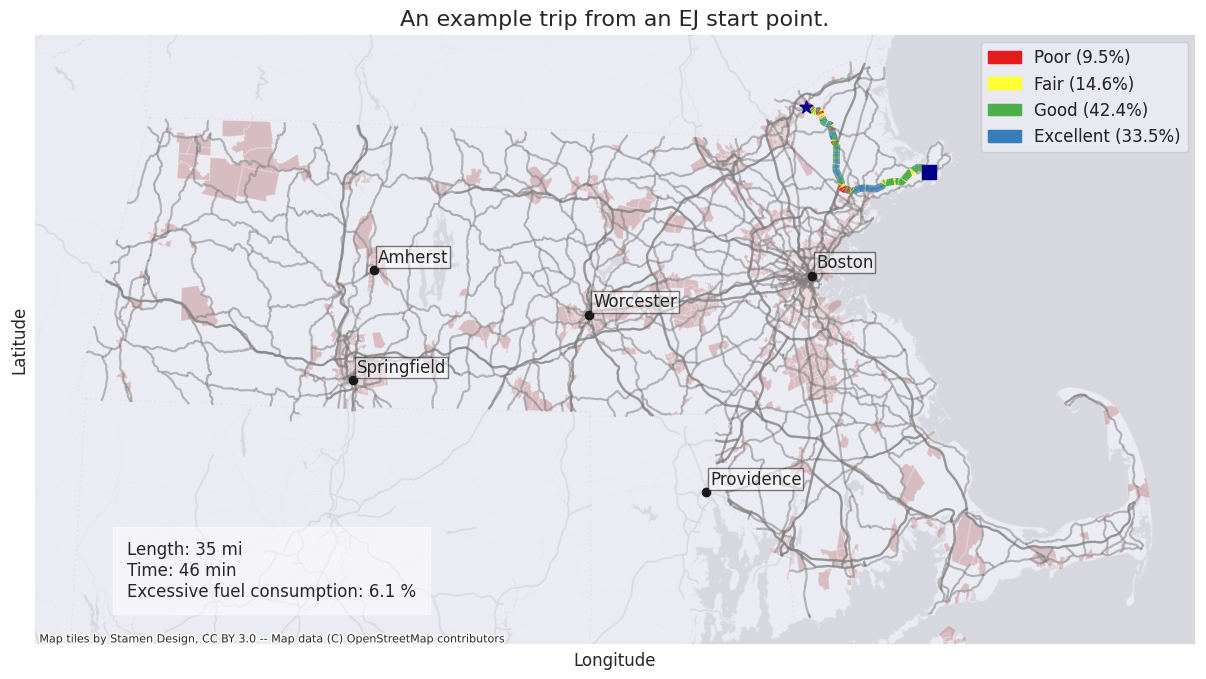

In [ ]:
index=index=np.where((Trips.Number_EJ > 0) & (Trips.length > 30) &(Trips.Percent_fuel_high>0.06))[0][4444]

font_text=12
font_title=16

# find the LODES indices for source and target nodes
LODES_index=json.loads(Trips.loc[index,'LODES_index'])
home_node=LODES.loc[LODES_index[0],'h_node']
work_node=LODES.loc[LODES_index[0],'w_node']

# calculate shortest path and return the matching edges
shortest_path = nx.shortest_path(G, home_node, work_node, weight='time')
edge_pairs_index, shortest_path_edges = shortest_path_data(shortest_path, edges)

# Create a color map for the conditions
color_map = {'Poor': 'red', 'Fair': 'orange', 'Good': 'green', 'Excellent': 'blue'}
color_map = {'Poor': '#fde725', 'Fair': '#35b778', 'Good': '#31688d', 'Excellent': '#440154'}
cmap = plt.cm.Set1

# Create a color map for the conditions
color_map = {'Poor': cmap(0), 'Fair': cmap(5), 'Good': cmap(2), 'Excellent': cmap(1)}  # You can change the color indices to select the colors you want

# Define a color map and a linestyle map
color_map = {'Poor': cmap(0), 'Fair': cmap(5), 'Good': cmap(2), 'Excellent': cmap(1)}
linestyle_map = {'Poor': '--', 'Fair': ':', 'Good': '-.', 'Excellent': '-'}

# Create a new column in the DataFrame that maps the condition to a color
# Make a copy of the dataframe before assigning colors
shortest_path_edges = shortest_path_edges.copy()
shortest_path_edges['color'] = shortest_path_edges['Condition'].map(color_map)


# Calculate total length of each condition
total_lengths = shortest_path_edges.groupby('Condition')['length'].sum()

# Calculate the percentage of total length for each condition
total_length = shortest_path_edges['length'].sum()
percentage_lengths = total_lengths / total_length * 100



# Plot the roads
edgescrs = edges.to_crs(epsg=3857)  # contextily requires data in Web Mercator projection (epsg:3857)
EJcrs = EJ.to_crs(epsg=3857)  # contextily requires data in Web Mercator projection (epsg:3857)
shortest_path_edges = shortest_path_edges.to_crs(epsg=3857)
fig, ax = plt.subplots(figsize=(15, 15))

edgescrs.plot(ax=ax, color='gray', alpha=0.6)
shortest_path_edges.plot(ax=ax, color=shortest_path_edges['color'], linewidth=5)


# Add a title and labels
EJcheck=Trips.loc[index,'Number_EJ']>0
if EJcheck:
  strr="an EJ"
else:
  strr="a non-EJ"
plt.title("An example trip from " +strr+ ' start point.', fontsize=font_title)
ax.set_ylabel("Latitude", fontsize=font_text)
ax.set_xlabel("Longitude", fontsize=font_text)

# Increase the font size of the tick labels
ax.tick_params(axis='both', which='major', labelsize=font_text)

# Add the base map
ctx.add_basemap(ax, source=ctx.providers.Stamen.TonerBackground, alpha=0.08)
# List of cities with corresponding coordinates

# Define the coordinate systems
crs_wgs = CRS("EPSG:4326")  # WGS84 coordinate system
crs_merc = CRS("EPSG:3857")  # Web Mercator coordinate system

# Create a transformer
transformer = Transformer.from_crs(crs_wgs, crs_merc)

# List of cities with corresponding coordinates
cities = {
    'Boston': (-71.0589, 42.3601),
    'Providence': (-71.4128, 41.8240),
    'Springfield': (-72.5898, 42.1015),
    'Worcester': (-71.8023, 42.2626),
    'Amherst': (-72.5199, 42.3732)
}

# Convert the coordinate of the city to Web Mercator
cities = {city: transformer.transform(lat, lon) for city, (lon, lat) in cities.items()}

# Add each city to the plot
for city, (x, y) in cities.items():
    ax.text(x, y, city, fontsize=12, ha='left', va='bottom',
            transform=ax.transData + ScaledTranslation(3/72, 3/72, fig.dpi_scale_trans),
            bbox=dict(facecolor='white', alpha=0.5, edgecolor='black', boxstyle='square,pad=0.1'))
    ax.plot(x, y, 'ko')  # 'ko' creates a black circle marker



# Plot EJ with dark red color and transparency
EJcrs.plot(ax=ax, color='darkred', alpha=0.2)
# Create the legend patches for road conditions, add percentage to the labels

start_node, end_node = G.nodes[home_node], G.nodes[work_node]
ax.scatter(start_node['x'], start_node['y'], c='darkblue', s=100, marker='s',zorder=10) # start is marked with a square
ax.scatter(end_node['x'], end_node['y'], c='darkblue', s=90, marker='*',zorder=10) # end is marked with a star

patches = [mpatches.Patch(color=color, label=f'{condition} ({percentage_lengths[condition]:.1f}%)') for condition, color in color_map.items()]

# Add the legend manually to the current Axes
leg1 = ax.legend(handles=patches, loc='upper right',fontsize=font_text)
ax.add_artist(leg1)

ax.grid(False)

# Hide axes ticks
ax.set_xticks([])
ax.set_yticks([])

# Box with details
xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()
length=int(np.round(Trips.loc[index]['length']))
time=int(np.round(Trips.loc[index]['time']))
fuel=np.round(Trips.loc[index]['Percent_fuel_high']*100,1) #this is a wrong value
info_text = f"Length: {length} mi\nTime: {time} min\nExcessive fuel consumption: {fuel} %"
plt.text(xmin + 0.08*(xmax-xmin), ymin + 0.08*(ymax-ymin), info_text, fontsize=font_text, bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 10})

plt.savefig("plots/exampleEJ2.png", dpi=300,bbox_inches='tight')


plt.show()


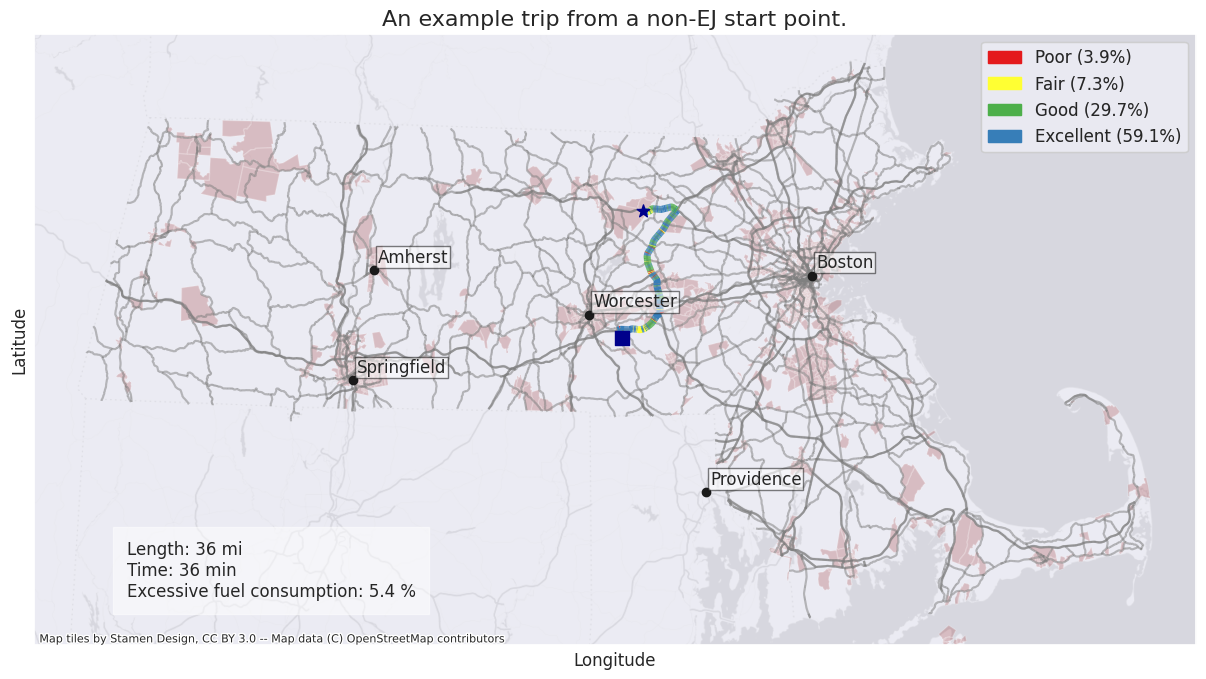

In [ ]:
index=np.where((Trips.Number_EJ == 0) & (Trips.length > 20))[0][-10] #72103

font_text=12
font_title=16

# find the LODES indices for source and target nodes
LODES_index=json.loads(Trips.loc[index,'LODES_index'])
home_node=LODES.loc[LODES_index[0],'h_node']
work_node=LODES.loc[LODES_index[0],'w_node']

# calculate shortest path and return the matching edges
shortest_path = nx.shortest_path(G, home_node, work_node, weight='time')
edge_pairs_index, shortest_path_edges = shortest_path_data(shortest_path, edges)

# Create a color map for the conditions
color_map = {'Poor': 'red', 'Fair': 'orange', 'Good': 'green', 'Excellent': 'blue'}
color_map = {'Poor': '#fde725', 'Fair': '#35b778', 'Good': '#31688d', 'Excellent': '#440154'}
cmap = plt.cm.Set1

# Create a color map for the conditions
color_map = {'Poor': cmap(0), 'Fair': cmap(5), 'Good': cmap(2), 'Excellent': cmap(1)}  # You can change the color indices to select the colors you want

# Define a color map and a linestyle map
color_map = {'Poor': cmap(0), 'Fair': cmap(5), 'Good': cmap(2), 'Excellent': cmap(1)}
linestyle_map = {'Poor': '--', 'Fair': ':', 'Good': '-.', 'Excellent': '-'}

# Create a new column in the DataFrame that maps the condition to a color
# Make a copy of the dataframe before assigning colors
shortest_path_edges = shortest_path_edges.copy()
shortest_path_edges['color'] = shortest_path_edges['Condition'].map(color_map)


# Calculate total length of each condition
total_lengths = shortest_path_edges.groupby('Condition')['length'].sum()

# Calculate the percentage of total length for each condition
total_length = shortest_path_edges['length'].sum()
percentage_lengths = total_lengths / total_length * 100



# Plot the roads
edgescrs = edges.to_crs(epsg=3857)  # contextily requires data in Web Mercator projection (epsg:3857)
EJcrs = EJ.to_crs(epsg=3857)  # contextily requires data in Web Mercator projection (epsg:3857)
shortest_path_edges = shortest_path_edges.to_crs(epsg=3857)
fig, ax = plt.subplots(figsize=(15, 15))

edgescrs.plot(ax=ax, color='gray', alpha=0.6)
shortest_path_edges.plot(ax=ax, color=shortest_path_edges['color'], linewidth=5)

# Add a title and labels
EJcheck=Trips.loc[index,'Number_EJ']>0
if EJcheck:
  strr="an EJ"
else:
  strr="a non-EJ"
plt.title("An example trip from " +strr+ ' start point.', fontsize=font_title)
ax.set_ylabel("Latitude", fontsize=font_text)
ax.set_xlabel("Longitude", fontsize=font_text)

# Increase the font size of the tick labels
ax.tick_params(axis='both', which='major', labelsize=font_text)

# Add the base map
ctx.add_basemap(ax, source=ctx.providers.Stamen.TonerBackground, alpha=0.08)
# List of cities with corresponding coordinates

# Define the coordinate systems
crs_wgs = CRS("EPSG:4326")  # WGS84 coordinate system
crs_merc = CRS("EPSG:3857")  # Web Mercator coordinate system

# Create a transformer
transformer = Transformer.from_crs(crs_wgs, crs_merc)

# List of cities with corresponding coordinates
cities = {
    'Boston': (-71.0589, 42.3601),
    'Providence': (-71.4128, 41.8240),
    'Springfield': (-72.5898, 42.1015),
    'Worcester': (-71.8023, 42.2626),
    'Amherst': (-72.5199, 42.3732)
}

# Convert the coordinate of the city to Web Mercator
cities = {city: transformer.transform(lat, lon) for city, (lon, lat) in cities.items()}

# Add each city to the plot
for city, (x, y) in cities.items():
    ax.text(x, y, city, fontsize=12, ha='left', va='bottom',
            transform=ax.transData + ScaledTranslation(3/72, 3/72, fig.dpi_scale_trans),
            bbox=dict(facecolor='white', alpha=0.5, edgecolor='black', boxstyle='square,pad=0.1'))
    ax.plot(x, y, 'ko')  # 'ko' creates a black circle marker



# Plot EJ with dark red color and transparency
EJcrs.plot(ax=ax, color='darkred', alpha=0.2)
# Create the legend patches for road conditions, add percentage to the labels
start_node, end_node = G.nodes[home_node], G.nodes[work_node]
ax.scatter(start_node['x'], start_node['y'], c='darkblue', s=100, marker='s',zorder=10) # start is marked with a square
ax.scatter(end_node['x'], end_node['y'], c='darkblue', s=90, marker='*',zorder=10) # end is marked with a star
patches = [mpatches.Patch(color=color, label=f'{condition} ({percentage_lengths[condition]:.1f}%)') for condition, color in color_map.items()]

# Add the legend manually to the current Axes
leg1 = ax.legend(handles=patches, loc='upper right',fontsize=font_text)
ax.add_artist(leg1)

ax.grid(False)

# Hide axes ticks
ax.set_xticks([])
ax.set_yticks([])

# Box with details
xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()
length=int(np.round(Trips.loc[index]['length']))
time=int(np.round(Trips.loc[index]['time']))
fuel=np.round(Trips.loc[index]['Percent_fuel_high']*100,1) #this is a wrong value
info_text = f"Length: {length} mi\nTime: {time} min\nExcessive fuel consumption: {fuel} %"
plt.text(xmin + 0.08*(xmax-xmin), ymin + 0.08*(ymax-ymin), info_text, fontsize=font_text, bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 10})

plt.savefig("plots/examplenonEJ2.png", dpi=300,bbox_inches='tight')


plt.show()


# Overall plots of road and EJ

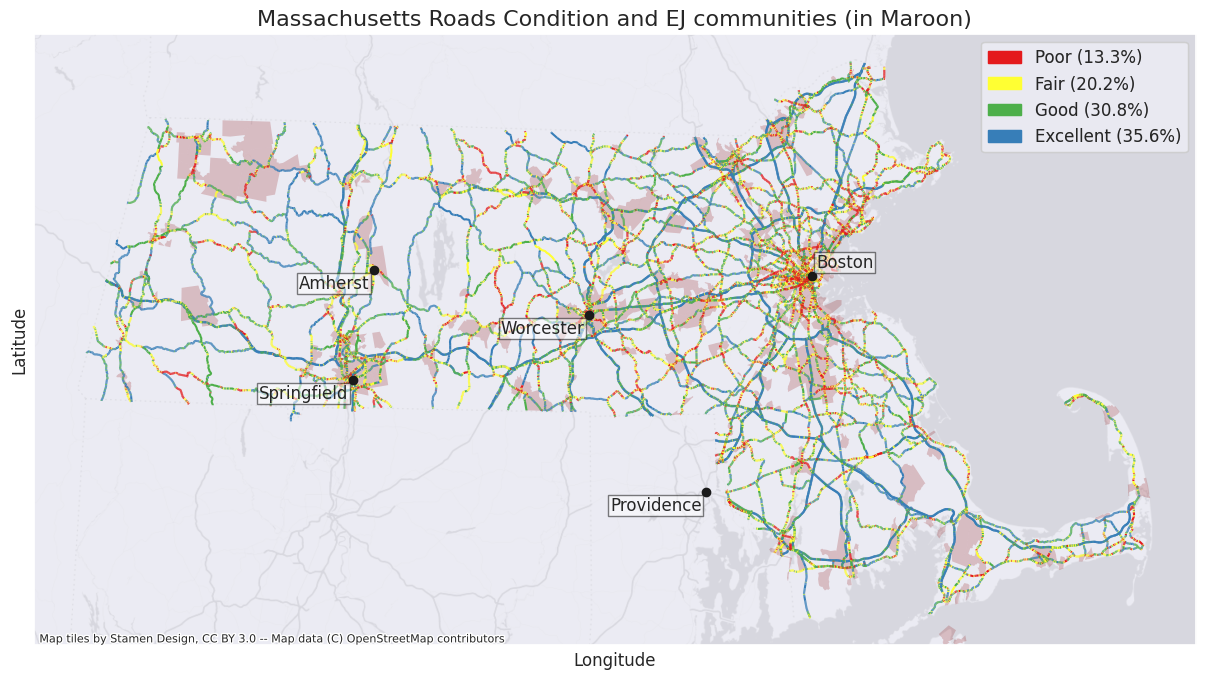

In [ ]:
fig, ax1 = plt.subplots(figsize=(15, 15))
# Define a color map and a linestyle map
color_map = {'Poor': cmap(0), 'Fair': cmap(5), 'Good': cmap(2), 'Excellent': cmap(1)}
linestyle_map = {'Poor': '--', 'Fair': ':', 'Good': '-.', 'Excellent': '-'}
edgescrs = edges.to_crs(epsg=3857)
edgescrs = edgescrs.copy()  # It's a good practice to use copy to not modify the original data
edgescrs['color'] = edgescrs['Condition'].map(color_map)
edgescrs.plot(ax=ax1, color=edgescrs['color'], alpha=1,linewidth=1.5)

ctx.add_basemap(ax=ax1, source=ctx.providers.Stamen.TonerBackground, alpha=0.08)
EJcrs.plot(ax=ax1,color='darkred', alpha=0.2, linewidth=0)
# Add each city to the plot
for city, (x, y) in cities.items():
    if city == 'Boston':
        ha, va = 'left', 'bottom'
        trans = ax1.transData + ScaledTranslation(3/72, 3/72, fig.dpi_scale_trans)
    else:
        ha, va = 'right', 'top'
        trans = ax1.transData + ScaledTranslation(-3/72, -3/72, fig.dpi_scale_trans)

    ax1.text(x, y, city, fontsize=12, ha=ha, va=va,
             transform=trans,
             bbox=dict(facecolor='white', alpha=0.5, edgecolor='black', boxstyle='square,pad=0.1'))
    ax1.plot(x, y, 'ko')  # 'ko' creates a black circle marker

# Calculate total length of each condition
total_lengths = shortest_path_edges.groupby('Condition')['length'].sum()

# Calculate the percentage of total length for each condition
total_lengths = edgescrs.groupby('Condition')['length'].sum()
total_length = edgescrs['length'].sum()
percentage_lengths = total_lengths / total_length * 100
patches = [mpatches.Patch(color=color, label=f'{condition} ({percentage_lengths[condition]:.1f}%)') for condition, color in color_map.items()]
# Add the legend manually to the current Axes
leg1 = ax1.legend(handles=patches, loc='upper right',fontsize=font_text)
ax1.add_artist(leg1)
ax1.set_title('Massachusetts Roads Condition and EJ communities (in Maroon)', fontsize=font_title)
ax1.set_ylabel("Latitude", fontsize=font_text)
ax1.set_xlabel("Longitude", fontsize=font_text)

ax1.grid(False)

# Hide axes ticks
ax1.set_xticks([])
ax1.set_yticks([])

plt.savefig("plots/roadandEJ.png", dpi=300,bbox_inches='tight')


plt.show()


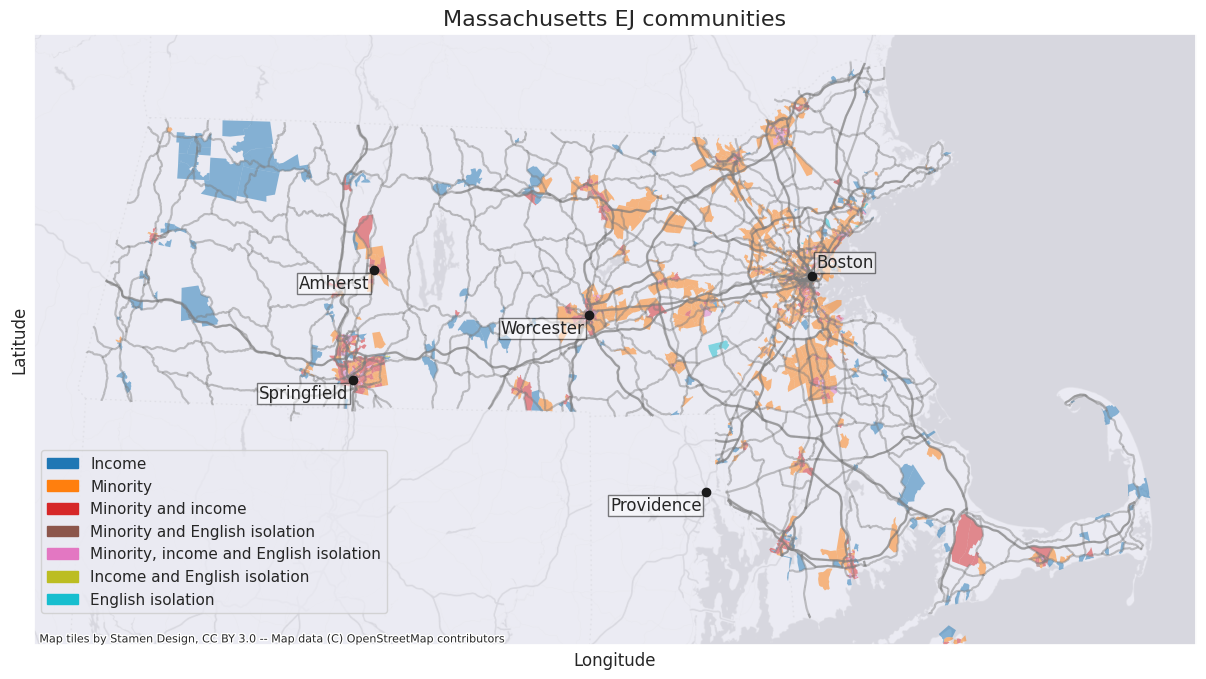

In [ ]:

import matplotlib.cm as mcm


# creating a color map
unique_values = EJcrs['EJ_CRIT_DE'].unique()
colors = mcm.tab10(np.linspace(0, 1, len(unique_values)))
color_map = dict(zip(unique_values, colors))

# generating a new column of color values
EJcrs['color'] = EJcrs['EJ_CRIT_DE'].map(color_map)

# plotting
fig, ax1 = plt.subplots(figsize=(15, 15))
edgescrs.plot(ax=ax1, color='gray', alpha=0.5, linewidth=1.5)

ctx.add_basemap(ax=ax1, source=ctx.providers.Stamen.TonerBackground, alpha=0.08)
EJcrs.plot(ax=ax1, color=EJcrs['color'], alpha=0.5, linewidth=0)


# Add each city to the plot
for city, (x, y) in cities.items():
    if city == 'Boston':
        ha, va = 'left', 'bottom'
        trans = ax1.transData + ScaledTranslation(3/72, 3/72, fig.dpi_scale_trans)
    else:
        ha, va = 'right', 'top'
        trans = ax1.transData + ScaledTranslation(-3/72, -3/72, fig.dpi_scale_trans)

    ax1.text(x, y, city, fontsize=12, ha=ha, va=va,
             transform=trans,
             bbox=dict(facecolor='white', alpha=0.5, edgecolor='black', boxstyle='square,pad=0.1'))
    ax1.plot(x, y, 'ko')  # 'ko' creates a black circle marker

ax1.set_title('Massachusetts EJ communities', fontsize=font_title)
ax1.set_ylabel("Latitude", fontsize=font_text)
ax1.set_xlabel("Longitude", fontsize=font_text)

ax1.grid(False)

# Hide axes ticks
ax1.set_xticks([])
ax1.set_yticks([])

#plt.savefig("plots/roadandEJ.png", dpi=300,bbox_inches='tight')


# creating legend
patches = [mpatches.Patch(color=v, label=k) for k, v in color_map.items()]
ax1.legend(handles=patches, loc='lower left', bbox_to_anchor=(0, 0.04))


plt.savefig("plots/EJ.png", dpi=300,bbox_inches='tight')

plt.show()

# Comparative Plots

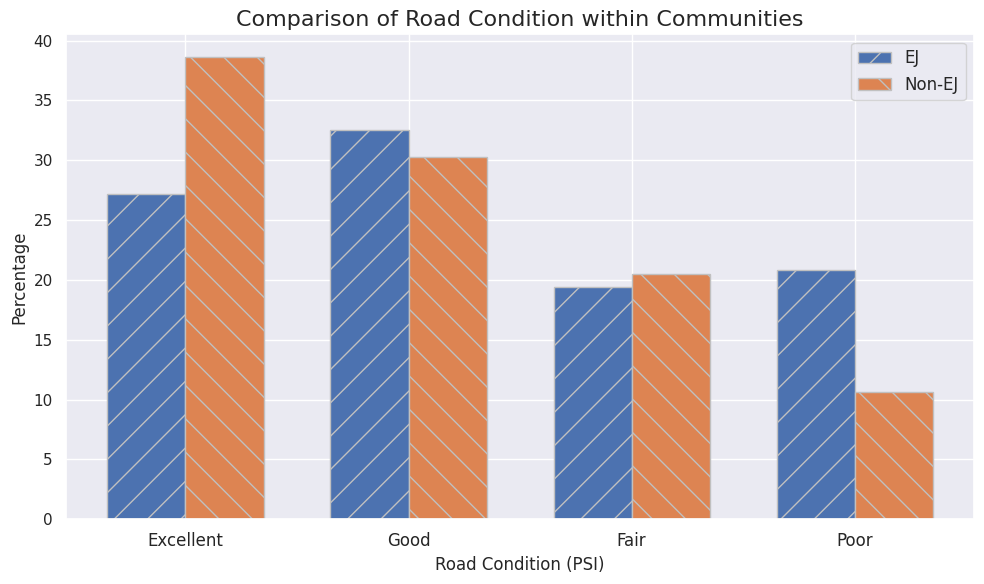

In [ ]:
data = {
    'Conditions': ['E', 'G', 'F', 'P'],
    'EJ': np.array([0.272, 0.325, 0.194, 0.208])*100,
    'Non-EJ': np.array([0.386, 0.303, 0.205, 0.106])*100
}

df = pd.DataFrame(data)

# Set the 'Conditions' column as the index
df.set_index('Conditions', inplace=True)

# Compute necessary parameters
N = len(df.index)
ind = np.arange(N)
width = 0.35  # width of the bars

fig, ax = plt.subplots(figsize=(10, 6))

# Plot each category with different texture
rects1 = ax.bar(ind, df['EJ'], width, hatch='/', label='EJ', edgecolor='silver')
rects2 = ax.bar(ind+width, df['Non-EJ'], width, hatch='\\', label='Non-EJ', edgecolor='silver')

# Add labels and title
ax.set_xlabel('Road Condition (PSI)', fontsize=12)
ax.set_ylabel('Percentage', fontsize=12)
ax.set_title('Comparison of Road Condition within Communities', fontsize=16)

# Set the x ticks
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(('Excellent', 'Good', 'Fair', 'Poor'), rotation=0, fontsize=12)

ax.legend(fontsize=12)
fig.tight_layout()
plt.savefig("plots/EJ_Roads.png", dpi=300,bbox_inches='tight')

plt.show()


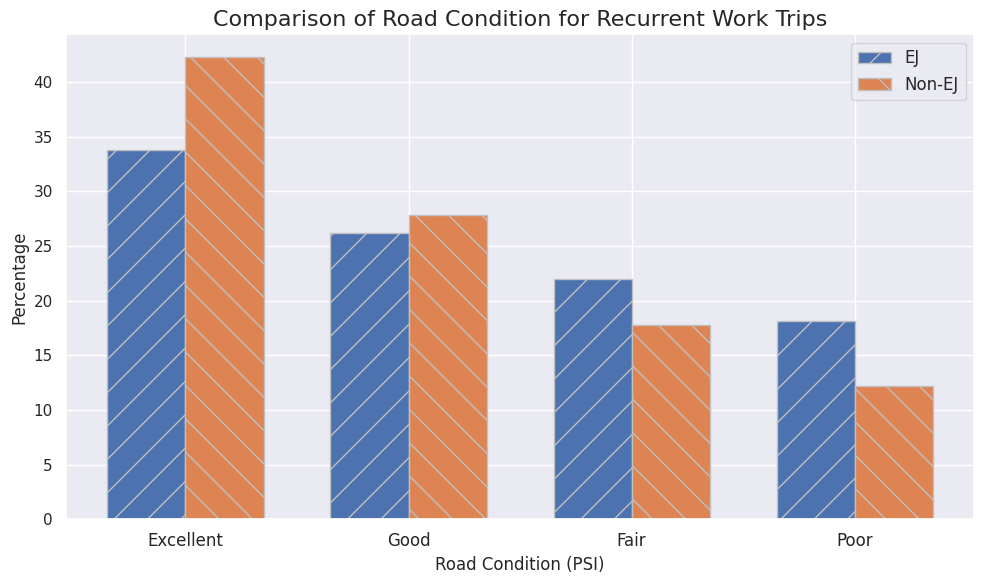

In [ ]:

df=Tripsl2.copy()
df['Community_Type'] = ['EJ' if ej > 0 else 'Non-EJ' for ej in df['Number_EJ']]
condition_means = df.groupby('Community_Type')[['Percent_Excellent', 'Percent_Good', 'Percent_Fair', 'Percent_Poor']].mean()*100
condition_means = condition_means.transpose()

N = len(condition_means.index)
ind = np.arange(N)
width = 0.35  # width of the bars

fig, ax = plt.subplots(figsize=(10, 6))

# Plot each category with different texture
rects1 = ax.bar(ind - width/2, condition_means['EJ'], width,
                hatch='/', label='EJ', edgecolor='silver')
rects2 = ax.bar(ind + width/2, condition_means['Non-EJ'], width,
                hatch='\\', label='Non-EJ', edgecolor='silver')

ax.set_title('Comparison of Road Condition for Recurrent Work Trips', fontsize=16)
ax.set_xlabel('Road Condition (PSI)', fontsize=12)
ax.set_ylabel('Percentage', fontsize=12)
ax.set_xticks(ind)
ax.set_xticklabels(['Excellent', 'Good', 'Fair', 'Poor'], rotation=0, fontsize=12)

ax.legend(fontsize=12)
fig.tight_layout()
plt.savefig("plots/EJ_TripCondition.png", dpi=300,bbox_inches='tight')
plt.show()


Fuel High

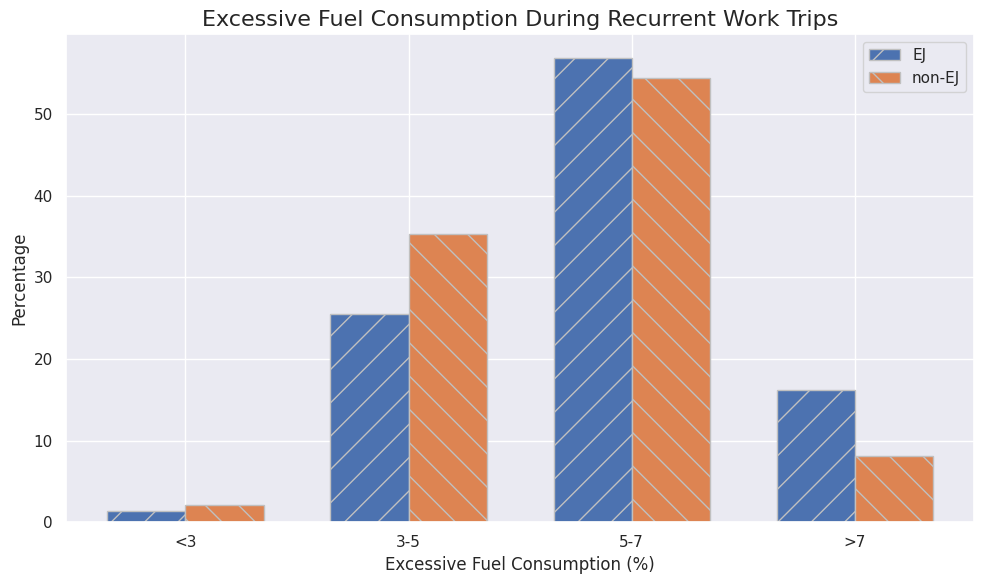

In [ ]:
df_ej = df[df['Community_Type'] == 'EJ']
df_non_ej = df[df['Community_Type'] == 'Non-EJ']
# Define the bins and their labels
bins = [-np.inf, 3/100, 5/100, 7/100,np.inf]
labels = ['<3', '3-5','5-7', '>7']

# Create copies of the DataFrame slices
df_ej_copy = df_ej.copy()
df_non_ej_copy = df_non_ej.copy()

# Create a new column 'fuel_high_bins' in both copied DataFrames using pd.cut to bin the data
df_ej_copy['fuel_high_bins'] = pd.cut(df_ej_copy['Percent_fuel_high'], bins=bins, labels=labels)
df_non_ej_copy['fuel_high_bins'] = pd.cut(df_non_ej_copy['Percent_fuel_high'], bins=bins, labels=labels)

# Calculate the percentage for each bin
ej_percentages = df_ej_copy['fuel_high_bins'].value_counts(normalize=True) * 100
non_ej_percentages = df_non_ej_copy['fuel_high_bins'].value_counts(normalize=True) * 100


# Plot the bar chart
ej_values = ej_percentages.reindex(labels).tolist()
non_ej_values = non_ej_percentages.reindex(labels).tolist()

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(10,6))
rects1 = ax.bar(x - width/2, ej_values, width, label='EJ',hatch='/', edgecolor='silver')
rects2 = ax.bar(x + width/2, non_ej_values, width, label='non-EJ',hatch='\\', edgecolor='silver')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Excessive Fuel Consumption (%)', fontsize=12)
ax.set_ylabel('Percentage', fontsize=12)
ax.set_title('Excessive Fuel Consumption During Recurrent Work Trips', fontsize=16)
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()
plt.savefig("plots/EJ_Trip_FuelConsumption.png", dpi=300,bbox_inches='tight')
plt.show()


Fuel Low

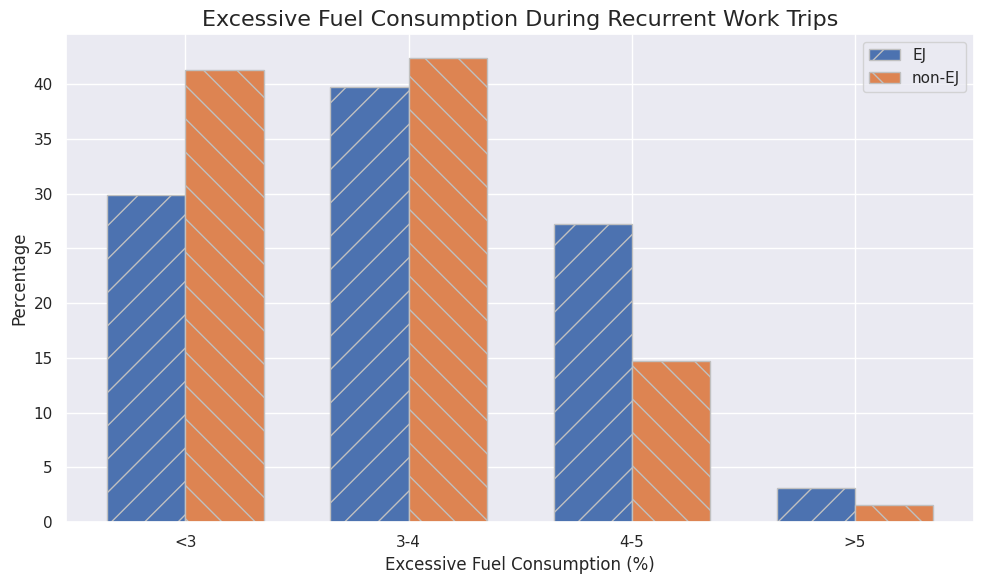

In [ ]:
df_ej = df[df['Community_Type'] == 'EJ']
df_non_ej = df[df['Community_Type'] == 'Non-EJ']
# Define the bins and their labels
bins = [-np.inf, 3/100, 4/100, 5/100,np.inf]
labels = ['<3', '3-4','4-5', '>5']

# Create copies of the DataFrame slices
df_ej_copy = df_ej.copy()
df_non_ej_copy = df_non_ej.copy()

# Create a new column 'fuel_high_bins' in both copied DataFrames using pd.cut to bin the data
df_ej_copy['fuel_low_bins'] = pd.cut(df_ej_copy['Percent_fuel_low'], bins=bins, labels=labels)
df_non_ej_copy['fuel_low_bins'] = pd.cut(df_non_ej_copy['Percent_fuel_low'], bins=bins, labels=labels)

# Calculate the percentage for each bin
ej_percentages = df_ej_copy['fuel_low_bins'].value_counts(normalize=True) * 100
non_ej_percentages = df_non_ej_copy['fuel_low_bins'].value_counts(normalize=True) * 100


# Plot the bar chart
ej_values = ej_percentages.reindex(labels).tolist()
non_ej_values = non_ej_percentages.reindex(labels).tolist()

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(10,6))
rects1 = ax.bar(x - width/2, ej_values, width, label='EJ',hatch='/', edgecolor='silver')
rects2 = ax.bar(x + width/2, non_ej_values, width, label='non-EJ',hatch='\\', edgecolor='silver')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Excessive Fuel Consumption (%)', fontsize=12)
ax.set_ylabel('Percentage', fontsize=12)
ax.set_title('Excessive Fuel Consumption During Recurrent Work Trips', fontsize=16)
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()
plt.savefig("plots/EJ_Trip_FuelConsumption_low.png", dpi=300,bbox_inches='tight')
plt.show()


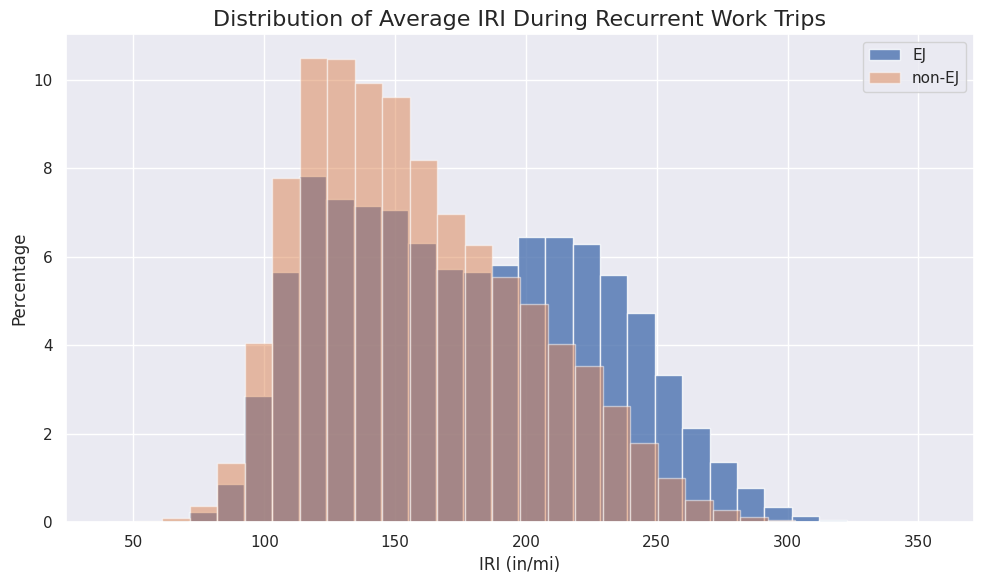

In [ ]:
df_ej = df[df['Community_Type'] == 'EJ']
df_non_ej = df[df['Community_Type'] == 'Non-EJ']

weights_ej = np.ones_like(df_ej['IRI_high']) / len(df_ej['IRI_high'])*100
weights_non_ej = np.ones_like(df_non_ej['IRI_high']) / len(df_non_ej['IRI_high'])*100

#plt.figure(figsize=(10,6))
fig, ax = plt.subplots(figsize=(10,6))
plt.hist(df_ej['IRI_high'], bins=30, alpha=0.8, label='EJ', weights=weights_ej)
plt.hist(df_non_ej['IRI_high'], bins=30, alpha=0.5, label='non-EJ', weights=weights_non_ej)
plt.xlabel('IRI (in/mi)', fontsize=12)
plt.ylabel('Percentage', fontsize=12)
plt.title('Distribution of Average IRI During Recurrent Work Trips', fontsize=16)
plt.legend(loc='upper right')
fig.tight_layout()
plt.savefig("plots/EJ_Trip_IRIv2.png", dpi=300,bbox_inches='tight')
plt.show()


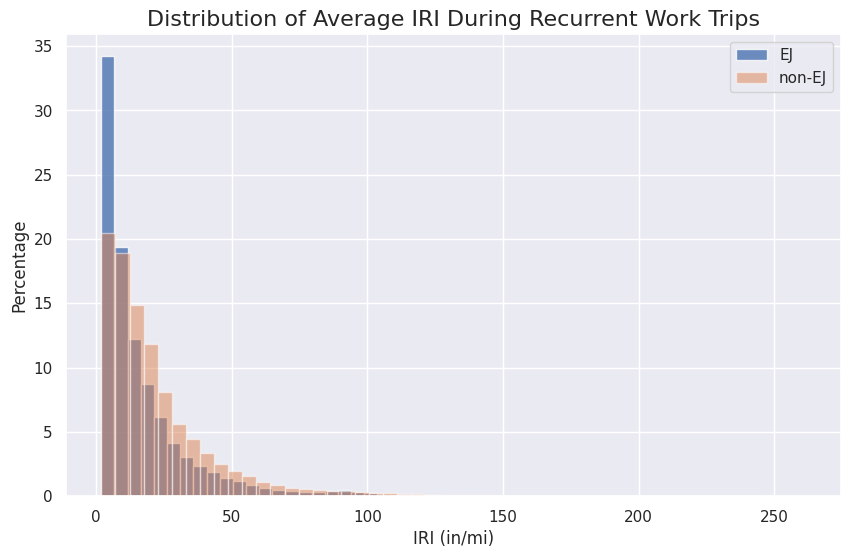

In [ ]:
df_ej = df[df['Community_Type'] == 'EJ']
df_non_ej = df[df['Community_Type'] == 'Non-EJ']

weights_ej = np.ones_like(df_ej['IRI_high']) / len(df_ej['IRI_high'])*100
weights_non_ej = np.ones_like(df_non_ej['IRI_high']) / len(df_non_ej['IRI_high'])*100

plt.figure(figsize=(10,6))
plt.hist(df_ej['length'], bins=50, alpha=0.8, label='EJ', weights=weights_ej)
plt.hist(df_non_ej['length'], bins=50, alpha=0.5, label='non-EJ', weights=weights_non_ej)
plt.xlabel('IRI (in/mi)', fontsize=12)
plt.ylabel('Percentage', fontsize=12)
plt.title('Distribution of Average IRI During Recurrent Work Trips', fontsize=16)
plt.legend(loc='upper right')
fig.tight_layout()
#plt.savefig("plots/EJ_Trip_IRI.png", dpi=300,bbox_inches='tight')
plt.show()


# TESTS

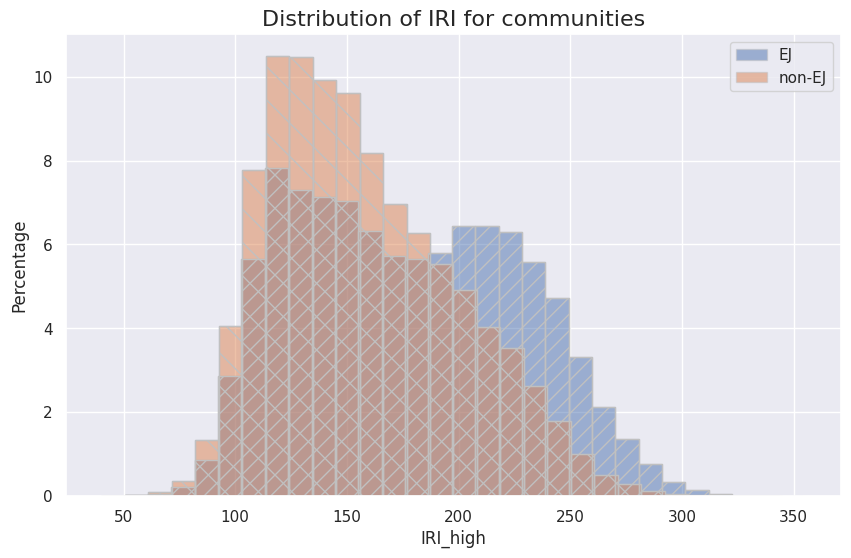

In [ ]:

df_ej = df[df['Community_Type'] == 'EJ']
df_non_ej = df[df['Community_Type'] == 'Non-EJ']

weights_ej = np.ones_like(df_ej['IRI_high']) / len(df_ej['IRI_high'])*100
weights_non_ej = np.ones_like(df_non_ej['IRI_high']) / len(df_non_ej['IRI_high'])*100

plt.figure(figsize=(10,6))

# Define the number of bins
n_bins = 30

# First create an unfilled histogram
counts_ej, bins_ej, _ = plt.hist(df_ej['IRI_high'], bins=n_bins, alpha=0.5,
                                 label='EJ', weights=weights_ej, edgecolor='silver')
counts_non_ej, bins_non_ej, _ = plt.hist(df_non_ej['IRI_high'], bins=n_bins, alpha=0.5,
                                         label='non-EJ', weights=weights_non_ej, edgecolor='silver')

# Overlay a bar chart with the same bin edges and add hatching
for i in range(n_bins-1):
    plt.bar(bins_ej[i], counts_ej[i], width=bins_ej[i+1]-bins_ej[i],
            hatch='//', align='edge', fill=False, edgecolor='silver')
    plt.bar(bins_non_ej[i], counts_non_ej[i], width=bins_non_ej[i+1]-bins_non_ej[i],
            hatch='\\', align='edge', fill=False, edgecolor='silver')

plt.xlabel('IRI_high', fontsize=12)
plt.ylabel('Percentage', fontsize=12)
plt.title('Distribution of IRI for communities', fontsize=16)
plt.legend(loc='upper right')
plt.show()


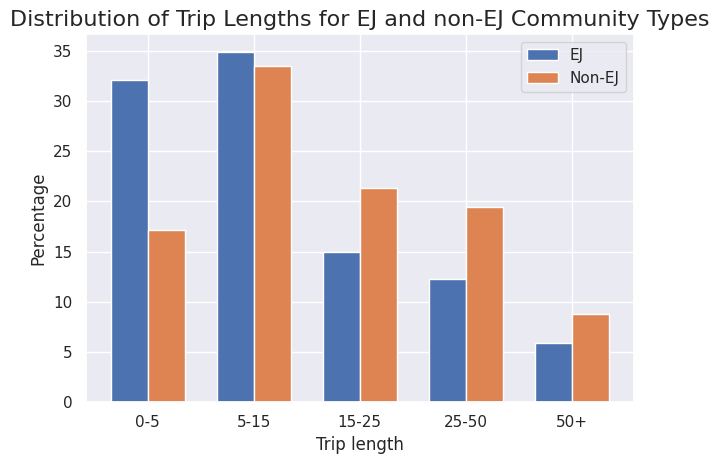

In [ ]:

df=Trips.copy()

# Define the bins and their labels
bins = [0, 5, 15, 25, 50, np.inf]
labels = ['0-5', '5-15', '15-25', '25-50', '50+']

df_ej = df[df['Community_Type'] == 'EJ']
df_non_ej = df[df['Community_Type'] == 'Non-EJ']

# Create copies of the DataFrame slices
df_ej_copy = df_ej.copy()
df_non_ej_copy = df_non_ej.copy()

# Create a new column 'length_bins' in both copied DataFrames using pd.cut to bin the data
df_ej_copy['length_bins'] = pd.cut(df_ej_copy['length'], bins=bins, labels=labels)
df_non_ej_copy['length_bins'] = pd.cut(df_non_ej_copy['length'], bins=bins, labels=labels)

# Calculate the percentage for each bin
ej_percentages = df_ej_copy['length_bins'].value_counts(normalize=True) * 100
non_ej_percentages = df_non_ej_copy['length_bins'].value_counts(normalize=True) * 100

# Plot the bar chart
ej_values = ej_percentages.reindex(labels).tolist()
non_ej_values = non_ej_percentages.reindex(labels).tolist()

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, ej_values, width, label='EJ')
rects2 = ax.bar(x + width/2, non_ej_values, width, label='Non-EJ')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Trip length', fontsize=12)
ax.set_ylabel('Percentage', fontsize=12)
ax.set_title('Distribution of Trip Lengths for EJ and non-EJ Community Types', fontsize=16)
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()
plt.show()

